# Korzystanie z gotowych modeli w Computer Vision

## Załadowanie danych

In [5]:
from torchvision.datasets import ImageFolder
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

In [6]:
# mean and std should be calculated!
train_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32
trainset = ImageFolder("../EX07 - IMAGES CLASSIFICATOR/data/train/", transform=train_transform)
testset = ImageFolder("../EX07 - IMAGES CLASSIFICATOR/data/test/", transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=512,
                                         shuffle=False)

In [7]:
torch.cuda.set_device(0)
device = torch.device("cuda")
device

device(type='cuda')

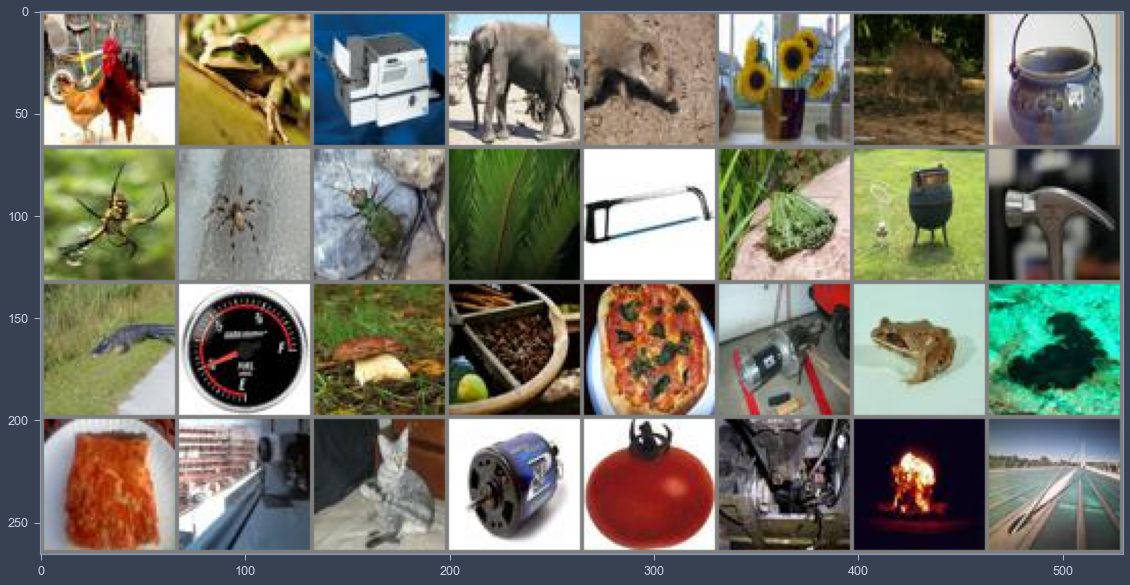

 bird  frog printer elephant swine flower swine   pot spider spider beetle  palm   saw  frog   pot hammer crocodilian gauge fungus spice pizza motor  frog  worm pizza camera   cat motor tomato motor  bomb bridge


In [8]:
plt.figure(figsize = (20,10))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % trainset.classes[labels[j]] for j in range(batch_size)))

In [9]:
len(trainset.classes)

50

## Model ResNet18

In [10]:
net = torchvision.models.resnet18(pretrained=True)
# wylaczanie uczenia parametrow wszedzie ale potem jest nadpisanie tej ostatniej - wszystkie warstwy poza ostatnią nie będą się zmieniały
for param in net.parameters():
    param.requires_grad = False

In [11]:
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Douczamy ostatnią warstwę
Podmieniamy warstwę w oparciu o jej nazwę:

In [12]:
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, len(trainset.classes))
# this layer has requires_grad=True - will be learning

In [13]:
net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [14]:
for epoch in range(3):  # loop over the dataset multiple times
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print('[%d] loss: %.3f' %
          (epoch+1 ,  running_loss / 2000))
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            # calculate outputs by running images through the network 
            outputs = net(images).cpu()
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))
    running_loss = 0.0

print('Finished Training')

[1] loss: 3.002
Accuracy of the network on test images: 1 %
[2] loss: 2.749
Accuracy of the network on test images: 2 %
[3] loss: 2.717
Accuracy of the network on test images: 1 %
Finished Training


#### Bez zamrażania wag:

In [15]:
net = torchvision.models.resnet18(pretrained=True)
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, len(trainset.classes))
net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [16]:
for epoch in range(3):  # loop over the dataset multiple times
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print('[%d] loss: %.3f' %
          (epoch+1 ,  running_loss / 2000))
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            # calculate outputs by running images through the network 
            outputs = net(images).cpu()
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))
    running_loss = 0.0

print('Finished Training')

[1] loss: 2.807
Accuracy of the network on test images: 2 %
[2] loss: 2.094
Accuracy of the network on test images: 0 %
[3] loss: 1.706
Accuracy of the network on test images: 2 %
Finished Training


### Dane o innych wymiarach
Będzie to problem dla warstw fully connected.

W CIFAR-100 obrazki są 2 razy mniejsze - 32x32.

In [17]:
trainset = torchvision.datasets.CIFAR100("data", train=True, download=True, transform=train_transform)
testset = torchvision.datasets.CIFAR100("data",train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=512,
                                         shuffle=False)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data\cifar-100-python.tar.gz to data
Files already downloaded and verified


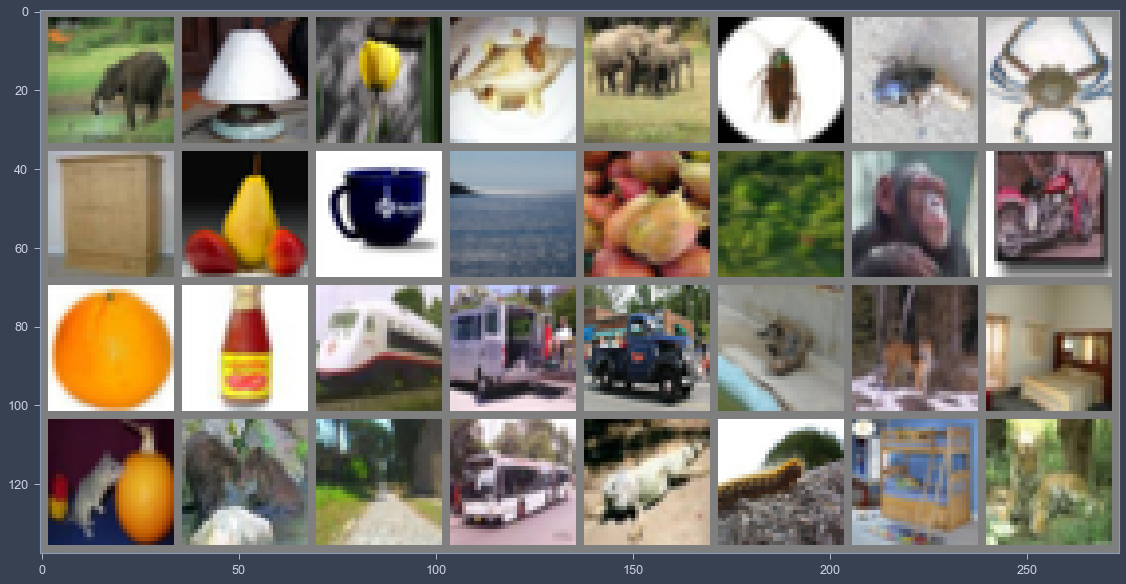

In [18]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = (20,10))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

Model od nowa:

In [19]:
net = torchvision.models.resnet18(pretrained=True)
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, len(trainset.classes))
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [20]:
for epoch in range(3):  # loop over the dataset multiple times
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print('[%d] loss: %.3f' %
          (epoch+1 ,  running_loss / 2000))
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            # calculate outputs by running images through the network 
            outputs = net(images).cpu()
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))
    running_loss = 0.0

print('Finished Training')

[1] loss: 2.517
Accuracy of the network on test images: 30 %
[2] loss: 1.999
Accuracy of the network on test images: 35 %
[3] loss: 1.746
Accuracy of the network on test images: 41 %
Finished Training


In [21]:
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Model uzyskuje jakies wyniki. Działa to dzięki warstwie adaptive AvgPool2d - jest to warstwa dopasowujaca okno usredniajace - dzieki temu siec sie nie psuje.

### Adaptive pooling

Docelowo wyjścia mają mieć rozmiar 5x7

In [22]:
pool_layer = nn.AdaptiveAvgPool2d((5,7))
in_example = torch.randn(1, 64, 18, 9)
pool_layer(in_example).size()

torch.Size([1, 64, 5, 7])

Albo 7x7:

In [23]:
pool_layer = nn.AdaptiveAvgPool2d(7)
in_example = torch.randn(1, 64, 10, 9)
pool_layer(in_example).size()

torch.Size([1, 64, 7, 7])

## Dodatkowe modele - PyTorch Hub
https://pytorch.org/hub/

Przykładowo generator generujący twarze celebrytów.

In [24]:
import torch

# trained on high-quality celebrity faces "celebA" dataset
# this model outputs 512 x 512 pixel images
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celebAHQ-512',
                       pretrained=True, useGPU=False)

Downloading: "https://github.com/facebookresearch/pytorch_GAN_zoo/archive/hub.zip" to C:\Users\01149762/.cache\torch\hub\hub.zip
Downloading: "https://dl.fbaipublicfiles.com/gan_zoo/PGAN/celebaHQ16_december_s7_i96000-9c72988c.pth" to C:\Users\01149762/.cache\torch\hub\checkpoints\celebaHQ16_december_s7_i96000-9c72988c.pth


  0%|          | 0.00/264M [00:00<?, ?B/s]

Average network found !


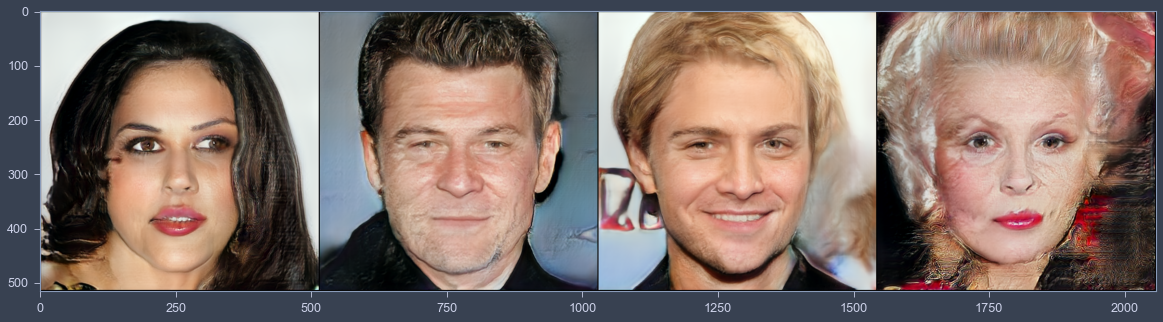

In [25]:
num_images = 4
noise, _ = model.buildNoiseData(num_images)
with torch.no_grad():
    generated_images = model.test(noise)

# let's plot these images using torchvision and matplotlib
import matplotlib.pyplot as plt
import torchvision
plt.figure(figsize = (20,10))
grid = torchvision.utils.make_grid(generated_images.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())

Using cache found in C:\Users\01149762/.cache\torch\hub\facebookresearch_pytorch_GAN_zoo_hub
Downloading: "https://dl.fbaipublicfiles.com/gan_zoo/DCGAN_fashionGen-1d67302.pth" to C:\Users\01149762/.cache\torch\hub\checkpoints\DCGAN_fashionGen-1d67302.pth


  0%|          | 0.00/39.7M [00:00<?, ?B/s]

Average network found !


c:\users\01149762\documents\ai\neural-networks-intro\venv\lib\site-packages\torch\nn\functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


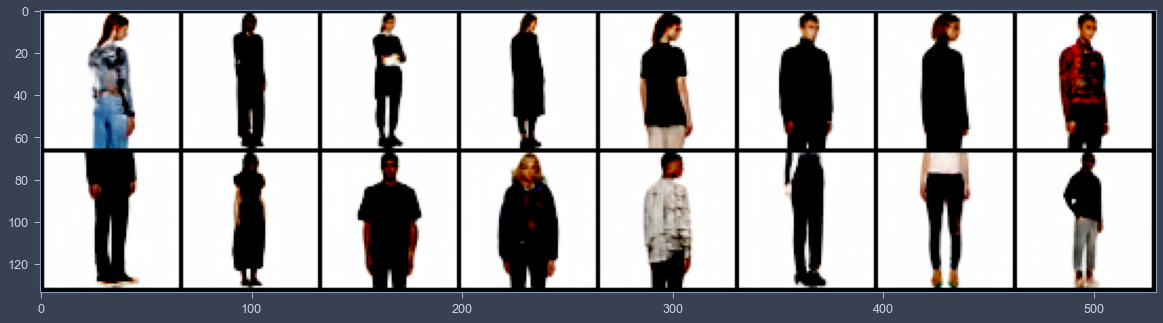

In [26]:
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub', 'DCGAN', pretrained=True, useGPU=False)
num_images = 16
noise, _ = model.buildNoiseData(num_images)
with torch.no_grad():
    generated_images = model.test(noise)

# let's plot these images using torchvision and matplotlib
import matplotlib.pyplot as plt
import torchvision
plt.figure(figsize = (20,10))
plt.imshow(torchvision.utils.make_grid(generated_images).permute(1, 2, 0).cpu().numpy())
# plt.show()

## Generacja głosu

In [27]:
tacotron2 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tacotron2', model_math='fp16')
tacotron2 = tacotron2.to(device)
tacotron2.eval()

Using cache found in C:\Users\01149762/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
C:\Users\01149762/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
C:\Users\01149762/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


Tacotron2(
  (embedding): Embedding(148, 512)
  (encoder): Encoder(
    (convolutions): ModuleList(
      (0): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (lstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (prenet): Prenet(
      (layers): ModuleList(
        (0): LinearNorm(
          (lin

In [28]:
waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='fp16')
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow.eval()

Using cache found in C:\Users\01149762/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
C:\Users\01149762/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch/SpeechSynthesis/Tacotron2\waveglow\model.py:55: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at  ..\aten\src\ATen\native\BatchLinearAlgebra.cpp:1940.)
  W = torch.qr(torch.FloatTensor(c, c).normal_())[0]


WaveGlow(
  (upsample): ConvTranspose1d(80, 80, kernel_size=(1024,), stride=(256,))
  (WN): ModuleList(
    (0): WN(
      (in_layers): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
        (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
        (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
        (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
        (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
      )
      (res_skip_layers): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
        (1): Conv1d(51

In [44]:
text = "Computer vision object detection using Faster R CNN"

In [45]:
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tts_utils')
sequences, lengths = utils.prepare_input_sequence([text])

Using cache found in C:\Users\01149762/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


In [46]:
with torch.no_grad():
    mel, _, _ = tacotron2.infer(sequences, lengths)
    audio = waveglow.infer(mel)
audio_numpy = audio[0].data.cpu().numpy()
rate = 22050

Mamy spektrogram:

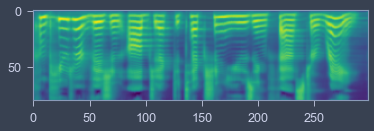

In [47]:
plt.imshow(mel.cpu().squeeze())

In [48]:
from IPython.display import Audio
Audio(audio_numpy, rate=rate)

## Dodatkowe zasoby:

- https://github.com/rwightman/pytorch-image-models
- https://github.com/Cadene/pretrained-models.pytorch
- https://modelzoo.co/
- Modele dla RLa: https://github.com/DLR-RM/rl-baselines3-zoo
- Modele w tensorflow: https://www.tensorflow.org/hub